In [9]:
import math 

import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data

sns.set()

In [10]:
INPUT_SIZE    = 3 * 32 * 32   # An image has 32 x 32 pixels each with Red/Green/Blue values.
BATCH_SIZE    = 100           # The size of input data took for one iteration of an epoch
LEARNING_RATE = 1e-3          # The speed of convergence
NUM_CLASSES   = 10            # The number of output classes. In this case, from 0 to 9
NUM_EPOCHS    = 10            # The number of times we loop over the whole dataset during training


In [11]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, 
                            transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, 
                                           shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, 
                           transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, 
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if batch_num % 100 == 0:  # Print every 100 batches                              
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            
            batch_num += 1            

        # If compute_accs is True, compute and return train and test accuracies
        if compute_accs:
            # Calculate the accuracy on the training data
            train_accuracy = accuracy(net, train_loader)
            train_accs.append(train_accuracy)
            # Calculate the accuracy on the test data
            test_accuracy = accuracy(net, test_loader)
            test_accs.append(test_accuracy)
            # Print accuracy after each epoch
            print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy {100 * train_accuracy:.2f}%, Test Accuracy {100 * test_accuracy:.2f}%')
            
            
    return train_accs, test_accs

def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=model_history['name'] + ' Test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=model_history['name'] + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])


In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# NetA: Simple linear classifier
class NetA(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc = nn.Linear(INPUT_SIZE, 10) # Instantiate the model
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image by reshaping it
        # NOTE: The -1 parameter automatically computes one dimension of the output tensor! 
        x = self.fc(x)  # Fully connected linear layer (no non-linearities)
        return x

# NetB: Linear layer with ReLU activation
class NetB(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(INPUT_SIZE, 300)
        self.layer2 = nn.Linear(300, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image
        x = F.relu(self.layer1(x))  # Fully connected with ReLU activation
        x = self.layer2(x)  # Fully connected linear layer
        return x

# NetC: Convolutional neural network
class NetC(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 25, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer = nn.Linear(25 * 14 * 14, 10)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))  # Convolution with ReLU activation
        x = self.pool(x)  # Max-pooling
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.layer(x)  # Fully connected linear layer
        return x


class NetD(nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, kernel_size=5)  # First convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max-pooling layer
        self.conv2 = nn.Conv2d(25, 25, kernel_size=3)  # Second convolutional layer
        self.fc1 = nn.Linear(3600, 100)  # First fully connected layer
        self.fc2 = nn.Linear(100, 10)  # Second fully connected layer

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolutional layer with ReLU activation
        x = self.pool(x)  # Apply max-pooling
        x = F.relu(self.conv2(x))  # Apply second convolutional layer with ReLU activation
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))  # Apply first fully connected layer with ReLU activation
        x = self.fc2(x)  # Apply second fully connected layer
        return x



==== Training NetA ====
Epoch [1/10], Step [100/500], Loss: 1.7272
Epoch [1/10], Step [200/500], Loss: 2.0519
Epoch [1/10], Step [300/500], Loss: 1.6705
Epoch [1/10], Step [400/500], Loss: 2.0194
Epoch [1/10], Step [500/500], Loss: 1.5701
Epoch [1/10], Train Accuracy 38.69%, Test Accuracy 37.46%
Epoch [2/10], Step [100/500], Loss: 1.7441
Epoch [2/10], Step [200/500], Loss: 1.7578
Epoch [2/10], Step [300/500], Loss: 1.6015
Epoch [2/10], Step [400/500], Loss: 1.7468
Epoch [2/10], Step [500/500], Loss: 1.8915
Epoch [2/10], Train Accuracy 40.78%, Test Accuracy 38.64%
Epoch [3/10], Step [100/500], Loss: 1.6155
Epoch [3/10], Step [200/500], Loss: 1.6452
Epoch [3/10], Step [300/500], Loss: 1.7327
Epoch [3/10], Step [400/500], Loss: 1.8294
Epoch [3/10], Step [500/500], Loss: 1.7475
Epoch [3/10], Train Accuracy 41.92%, Test Accuracy 39.17%
Epoch [4/10], Step [100/500], Loss: 1.6043
Epoch [4/10], Step [200/500], Loss: 1.6339
Epoch [4/10], Step [300/500], Loss: 1.6417
Epoch [4/10], Step [400/500]

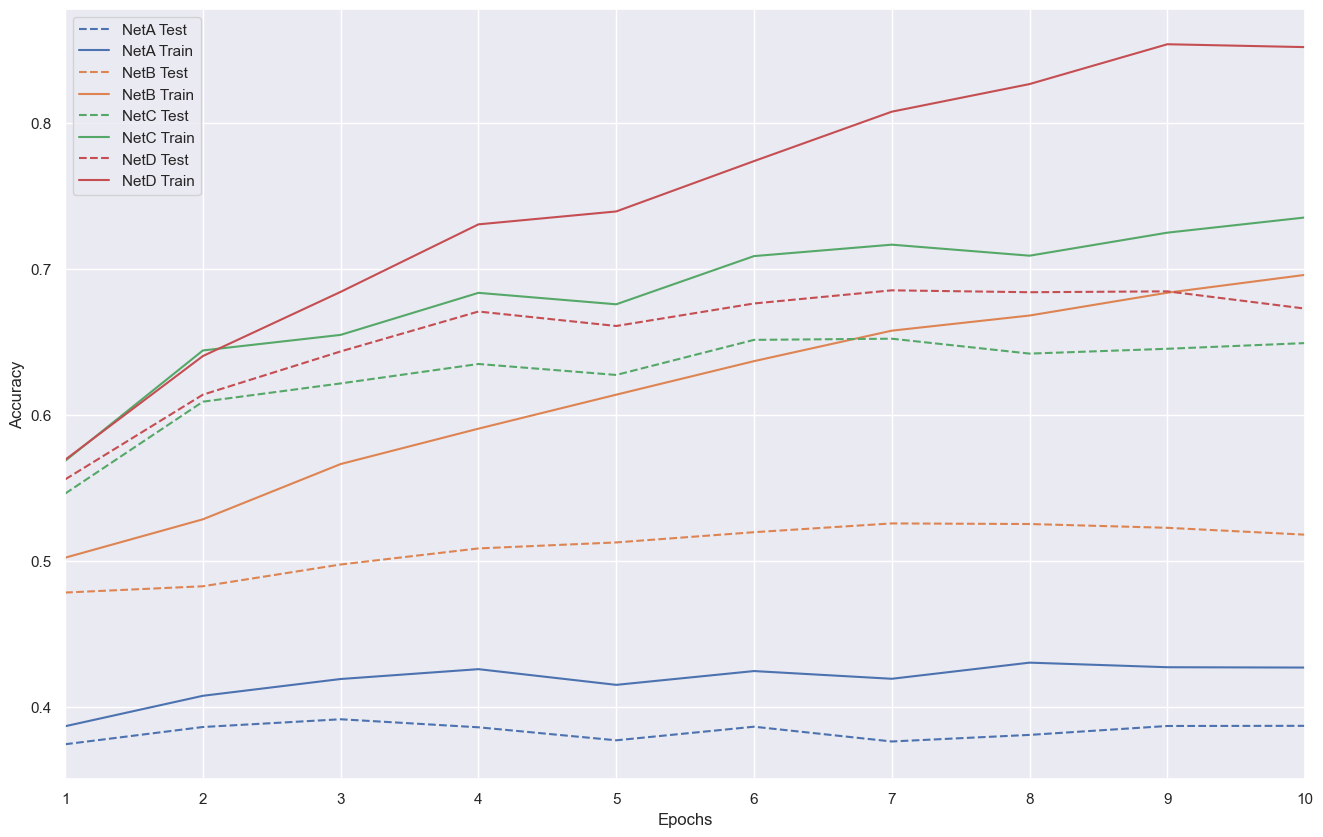

In [86]:
%%time 
nets = [NetA(), NetB(), NetC(), NetD()]
histories = []

for net in nets:
    net_name = type(net).__name__
    print(f'==== Training {net_name} ====')
    train_history, test_history = train(net, train_loader, test_loader, 
                                        num_epochs=NUM_EPOCHS, 
                                        learning_rate=LEARNING_RATE, 
                                        compute_accs=True)
    histories.append({
        'name': net_name, 
        'net': net, 
        'train_accs': train_history, 
        'test_accs': test_history
    })
plot_history(histories)